### Hello this project is to be presented to D.Charbel Boustany 
#### on behalf of Abdulelah Alsbiei, Omar Naji, Bassel Constantine and Mustafa Barakat
## Neighborhoods Comparison

##### first we import the needed libraries

In [13]:
import numpy as np # for math function
import pandas as pd
import json # to handle json files
from geopy.geocoders import Nominatim # get the lattitude and logtitude of an address
import requests # to retrieve data online
from pandas.io.json import json_normalize # to tranform json file into a pandas dataframe
import matplotlib.cm as cm 
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans # for clustring
import folium # for map rendering library
from IPython.display import HTML

In [14]:
# to widen the output of our dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#### we will be using the data of Newyork city and Toronto City
##### first we are going to prepare nyc data

In [15]:
with open('nyc.json') as json_data:
    newyork_data = json.load(json_data)

In [16]:
newyork_data

{'type': 'FeatureCollection',
 'totalFeatures': 306,
 'features': [{'type': 'Feature',
   'id': 'nyu_2451_34572.1',
   'geometry': {'type': 'Point',
    'coordinates': [-73.84720052054902, 40.89470517661]},
   'geometry_name': 'geom',
   'properties': {'name': 'Wakefield',
    'stacked': 1,
    'annoline1': 'Wakefield',
    'annoline2': None,
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.84720052054902,
     40.89470517661,
     -73.84720052054902,
     40.89470517661]}},
  {'type': 'Feature',
   'id': 'nyu_2451_34572.2',
   'geometry': {'type': 'Point',
    'coordinates': [-73.82993910812398, 40.87429419303012]},
   'geometry_name': 'geom',
   'properties': {'name': 'Co-op City',
    'stacked': 2,
    'annoline1': 'Co-op',
    'annoline2': 'City',
    'annoline3': None,
    'annoangle': 0.0,
    'borough': 'Bronx',
    'bbox': [-73.82993910812398,
     40.87429419303012,
     -73.82993910812398,
     40.87429419303012]}},
  {'type': 'Feature',
 

##### transform json data to df 

In [17]:
nyc_neighborhoods_data = newyork_data['features']
nyc_neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

In [18]:
column_names = ['District', 'Neighborhood', 'Latitude', 'Longitude'] 

nyc_neighborhoods = pd.DataFrame(columns=column_names)

for data in nyc_neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    nyc_neighborhoods = nyc_neighborhoods.append({'District': borough,
                                                  'Neighborhood': neighborhood_name,
                                                  'Latitude': neighborhood_lat,
                                                  'Longitude': neighborhood_lon}, ignore_index=True)

In [19]:
nyc_neighborhoods.head()

,District,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


#### fetching the coordinates of NYC

In [20]:
address = 'New York City, NY'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(' latitude is:{}, longitude is:{}.'.format(latitude, longitude))

 latitude is:40.7127281, longitude is:-74.0060152.


#### creating a map for nyc with taps on the districts

In [21]:
# creating the map based on the latitude and longitude
map_newyork = folium.Map(location=[latitude, longitude])

# addding taps on the map for every district and neighborhoods
for lat, lng, district, neighborhood in zip(nyc_neighborhoods['Latitude'], 
                                           nyc_neighborhoods['Longitude'], 
                                           nyc_neighborhoods['District'], 
                                           nyc_neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, district)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        popup=label,
        radius=3,
        weight=2,
        ).add_to(map_newyork)  
    
map_newyork

#### using the Foursquare API by passing the my credentials

In [22]:
# Foursquare API credentials 
CLIENT_ID = 'A1VPXW0G4VZLCKIMZUOGCWBXBGIY5UP21CRGT0R4OJXJOWBQ' 
CLIENT_SECRET = 'HK051UQF5HLYE5044ZAZ3R00GBQS05DCO25UV24Y531IYBQT' 
VERSION = '20180605'

#### we define a function to retrieve data on every venue in neighborhood, it takes list of names and list of coordinates as parameters and it gives a df with the required data retrieved from foursquare database

In [23]:
def NearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print('T', end='')
            
        # API RQUEST
        url = ('https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}'
               '&v={}&ll={},{}&intent=browse&radius={}&limit={}'
               .format(CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT))
            
        # get request from the API 
        results = None
        while results is None:
            try:
                results = requests.get(url).json()["response"]["venues"]
            except:
                print('F', end='')
                results = None
        
        venues_list.append([(name, lat, lng, v['name'], v['location']['lat'], 
                             v['location']['lng'], v['categories'][0]['name']) 
                            for v in results if len(v['categories']) > 0])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 
                             'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [24]:
# now we request the venues from the function above
NewYorkVenues = NearbyVenues(names=nyc_neighborhoods['Neighborhood'],
                             latitudes=nyc_neighborhoods['Latitude'],
                             longitudes=nyc_neighborhoods['Longitude']
                            )

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT

In [25]:
NewYorkVenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,40.894705,-73.847201,Pitman Deli,40.896744,-73.844398,Food
1,Wakefield,40.894705,-73.847201,Julio C Barber Shop 2,40.892648,-73.855725,Salon / Barbershop
2,Wakefield,40.894705,-73.847201,Ely Avenue,40.892967,-73.846539,Road
3,Wakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
4,Wakefield,40.894705,-73.847201,Shell,40.891771,-73.853213,Gas Station


In [26]:
# checking the number of venues in each neighbor.
NewYorkVenues.groupby('Neighborhood').size()

Neighborhood
Allerton                      93
Annadale                      82
Arden Heights                 78
Arlington                     87
Arrochar                      91
Arverne                       96
Astoria                       84
Astoria Heights               87
Auburndale                    67
Bath Beach                    91
Battery Park City             95
Bay Ridge                     87
Bay Terrace                  178
Baychester                    91
Bayside                       88
Bayswater                     92
Bedford Park                  88
Bedford Stuyvesant            94
Beechhurst                    99
Bellaire                      88
Belle Harbor                  92
Bellerose                     87
Belmont                       64
Bensonhurst                   87
Bergen Beach                  88
Blissville                    98
Bloomfield                    93
Boerum Hill                   94
Borough Park                  41
Breezy Point                  

In [27]:
#check how many venue type we have
print('There are {} uniques categories.'.format(len(NewYorkVenues['Venue Category'].unique())))

There are 587 uniques categories.


In [28]:
# now we do one-hot encoding to specifiy the most common venues in each neighbor.
nyc_onehot = pd.get_dummies(NewYorkVenues[['Venue Category']], prefix="", prefix_sep="")
nyc_onehot['Neighborhoods'] = NewYorkVenues['Neighborhood'] 
fixed_columns = [nyc_onehot.columns[-1]] + list(nyc_onehot.columns[:-1])
nyc_onehot = nyc_onehot[fixed_columns]
nyc_grouped = nyc_onehot.groupby('Neighborhoods').mean().reset_index()
nyc_grouped.head()

,Neighborhoods,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Gate,Airport Service,Airport Terminal,Airport Tram,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Astrologer,Athletics & Sports,Auditorium,Australian Restaurant,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baggage Claim,Baggage Locker,Bakery,Ballroom,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Bathing Area,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Border Crossing,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buddhist Temple,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campaign Office,Campground,Canal,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Carpet Store,Casino,Caucasian Restaurant,Cemetery,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Circus,City Hall,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Football Field,College Gym,College Lab,College Library,College Math Building,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Technology Building,College Theater,College Track,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Community College,Concert Hall,Conference Room,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Corporate Amenity,Corporate Cafeteria,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Cycle Studio,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Dosa Place,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,EV Charging Station,Eastern European Restaurant,Electronics Store,Elementary School,Embassy / Consulate,Emergency Room,Empanada Restaurant,Entertainment Service,Escape Room,Event Service,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Fair,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fire Station,Fish & Chips Shop,Fish Market,Fishing Spot,Fishing Store,Flea Market,Floating Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Forest,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Range,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Himalayan Restaurant,Hindu Temple,Historic Site,History Museum,Hobby Shop,Hockey Field,Home Service,Hookah Bar,Hospital,Hospit

In [29]:
def common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_cat = 5
indicators = ['st', 'nd', 'rd']

In [30]:
columns = ['Neighborhoods']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

nyc_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
nyc_neighborhoods_categories_sorted['Neighborhoods'] = nyc_grouped['Neighborhoods']

for ind in np.arange(nyc_grouped.shape[0]):
    nyc_neighborhoods_categories_sorted.iloc[ind, 1:] = common_venues(
        nyc_grouped.iloc[ind, :], num_top_cat)

nyc_neighborhoods_categories_sorted.head()

,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Allerton,Salon / Barbershop,Laundry Service,Bus Line,Doctor's Office,Chiropractor
1,Annadale,Pizza Place,Salon / Barbershop,American Restaurant,Tattoo Parlor,Nail Salon
2,Arden Heights,Road,Pool,Professional & Other Places,Moving Target,Church
3,Arlington,Church,Bus Stop,Road,Salon / Barbershop,Building
4,Arrochar,Bus Stop,Deli / Bodega,Nail Salon,Food Truck,Laundry Service


### now we apply k-means clustering

In [60]:
kclusters = 5

nyc_grouped_clustering = nyc_grouped.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nyc_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 4, 4, 4, 4, 4, 3, 4, 4, 4])

In [63]:
# add clustering labels
nyc_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

nyc_merged = nyc_neighborhoods.rename(columns={'Neighborhood': 'Neighborhoods'}).copy()
nyc_merged = nyc_merged.join(nyc_neighborhoods_categories_sorted.set_index('Neighborhoods'), on='Neighborhoods')

nyc_merged.head() 

,District,Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,Bronx,Wakefield,40.894705,-73.847201,2,Salon / Barbershop,Church,Laundry Service,Coworking Space,Food
1,Bronx,Co-op City,40.874294,-73.829939,4,Bus Line,Residential Building (Apartment / Condo),School,Other Great Outdoors,Parking
2,Bronx,Eastchester,40.887556,-73.827806,4,Automotive Shop,Bus Line,Deli / Bodega,Gas Station,Auto Dealership
3,Bronx,Fieldston,40.895437,-73.905643,4,College Academic Building,College Residence Hall,College Administrative Building,College Cafeteria,Residential Building (Apartment / Condo)
4,Bronx,Riverdale,40.890834,-73.912585,3,Residential Building (Apartment / Condo),Synagogue,Doctor's Office,Playground,Park
5,Bronx,Kingsbridge,40.881687,-73.902818,4,Laundry Service,Bank,Salon / Barbershop,Park,Building
6,Manhattan,Marble Hill,40.876551,-73.910660,2,Deli / Bodega,Salon / Barbershop,High School,Residential Building (Apartment / Condo),Furniture / Home Store
7,Bronx,Woodlawn,40.898273,-73.867315,4,Bar,Deli / Bodega,Salon / Barbershop,Pub,Bus Line
8,Bronx,Norwood,40.877224,-73.879391,0,Doctor's Office,Park,Medical Center,Deli / Bodega,Salon / Barbershop
9,Bronx,Williamsbridge,40.881039,-73.857446,2,Church,Salon / Barbershop,Deli / Bodega,Caribbean Restaurant,School


In [67]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9,
                          min_zoom=8, max_zoom=11)
pc = ["#4285f4", "#db4437", "#f4b400", "#0f9d58", "#ab47bc", "#00acc1", "#ff7043", 
      "#9e9d24", "#5c6bc0", "#f06292", "#00796b", "#c2185b", "#7e57c2", "#03a9f4", 
      "#8bc34a", "#fdd835", "#fb8c00", "#8d6e63", "#9e9e9e", "#607d8b"]
rainbow = pc[:5]

# add taps to the maps regarding the neighbors and their corresponding clusters
for lat, lon, poi, cluster in zip(nyc_merged['Latitude'], nyc_merged['Longitude'], 
                                  nyc_merged['Neighborhoods'], nyc_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        weight=1,
        popup=label,
        color='#333333',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
map_clusters

## Now we do the same proccess with Toronto Data

In [34]:
Toronto=pd.read_html('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M', header=0)
Toronto=Toronto[0]
Toronto.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [35]:
Toronto.columns = ['PostalCode', 'District', 'Neighborhood']
Toronto.head()

,PostalCode,District,Neighborhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [36]:
# as we saw there are some not assigned district so now we will exclude these records 
Toronto.drop(Toronto[Toronto['District']=='Not assigned'].index, inplace = True) 


In [37]:
Toronto.head()

,PostalCode,District,Neighborhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


### now we get the latitude and longitude

In [38]:
tor_lat = pd.read_csv('geopostal.csv')

In [39]:
tor_lat.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### add the latitude and longitude to data frame

In [40]:
Toronto.reset_index(drop=True, inplace=True)
Toronto['Latitude'] = -99999.9
Toronto['Longitude'] = -99999.9

for i in range(Toronto.shape[0]):
    postalcode = Toronto.loc[i, 'PostalCode']
    lat = tor_lat.loc[tor_lat['Postal Code'] == postalcode, 'Latitude'].squeeze()
    lng = tor_lat.loc[tor_lat['Postal Code'] == postalcode, 'Longitude'].squeeze()
    Toronto.loc[i, 'Latitude'] = lat
    Toronto.loc[i, 'Longitude'] = lng

In [41]:
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(' coordinate of Toronto are {}, {}.'.format(latitude, longitude))

 coordinate of Toronto are 43.6534817, -79.3839347.


In [42]:
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10,
                         min_zoom=9, max_zoom=11)

# add neighborhoods taps to map
for lat, lng, borough, neighborhood in zip(Toronto['Latitude'], Toronto['Longitude'], 
                                           Toronto['District'], Toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        weight=2,
        popup=label,
        color='#333333',
        fill=True,
        fill_color='#388e3c',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

In [43]:
TorontoVenues = NearbyVenues(names=Toronto['Neighborhood'],
                             latitudes=Toronto['Latitude'],
                             longitudes=Toronto['Longitude']
                            )

TTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTT

In [44]:
TorontoVenues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.753259,-79.329656,TTC stop #8380,43.752672,-79.326351,Bus Stop
1,Parkwoods,43.753259,-79.329656,Brookbanks Park,43.751976,-79.332140,Park
2,Parkwoods,43.753259,-79.329656,Subway,43.760334,-79.326906,Sandwich Place
3,Parkwoods,43.753259,-79.329656,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant
4,Parkwoods,43.753259,-79.329656,Yorkmills Wellness & Spa,43.756800,-79.325346,Spa


In [45]:
#check how many venue type we have
TorontoVenues.groupby('Neighborhood').size()


Neighborhood
Agincourt                                                                                                                                  93
Alderwood, Long Branch                                                                                                                     93
Bathurst Manor, Wilson Heights, Downsview North                                                                                            89
Bayview Village                                                                                                                            88
Bedford Park, Lawrence Manor East                                                                                                          87
Berczy Park                                                                                                                                84
Birch Cliff, Cliffside West                                                                                                            

In [46]:
print('There are {} uniques categories.'.format(len(TorontoVenues['Venue Category'].unique())))

There are 512 uniques categories.


In [47]:
tor_onehot = pd.get_dummies(TorontoVenues[['Venue Category']], prefix="", prefix_sep="")

tor_onehot['Neighborhoods'] = TorontoVenues['Neighborhood'] 

fixed_columns = [tor_onehot.columns[-1]] + list(tor_onehot.columns[:-1])
tor_onehot = tor_onehot[fixed_columns]

tor_onehot.head()

,Neighborhoods,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baggage Claim,Bakery,Ballroom,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blood Donation Center,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campaign Office,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Casino,Cemetery,Cha Chaan Teng,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,City Hall,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Engineering Building,College Football Field,College Gym,College History Building,College Hockey Rink,College Lab,College Library,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Technology Building,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Conference Room,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Corporate Cafeteria,Corporate Coffee Shop,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,EV Charging Station,Eastern European Restaurant,Electronics Store,Elementary School,Embassy / Consulate,Emergency Room,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flight School,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hindu Temple,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hospital Ward,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Industrial Estate,Insurance 

In [48]:
# Grouping rows by neighborhood and taking the mean of the frequency 
# of occurrence of each category for each neighborhood
tor_grouped = tor_onehot.groupby('Neighborhoods').mean().reset_index()
tor_grouped.head()

,Neighborhoods,ATM,Accessories Store,Acupuncturist,Adult Boutique,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,Alternative Healer,American Restaurant,Animal Shelter,Antique Shop,Aquarium,Arcade,Argentinian Restaurant,Art Gallery,Art Studio,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Assisted Living,Athletics & Sports,Auditorium,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Baggage Claim,Bakery,Ballroom,Bank,Bar,Baseball Field,Basketball Court,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Blood Donation Center,Board Shop,Boat or Ferry,Bookstore,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Center,Business Service,Butcher,Cable Car,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campaign Office,Campground,Candy Store,Cantonese Restaurant,Capitol Building,Car Wash,Caribbean Restaurant,Casino,Cemetery,Cha Chaan Teng,Cheese Shop,Chinese Breakfast Place,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,City Hall,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College & University,College Academic Building,College Administrative Building,College Arts Building,College Auditorium,College Basketball Court,College Bookstore,College Cafeteria,College Classroom,College Communications Building,College Engineering Building,College Football Field,College Gym,College History Building,College Hockey Rink,College Lab,College Library,College Quad,College Rec Center,College Residence Hall,College Science Building,College Soccer Field,College Stadium,College Technology Building,College Theater,College Track,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Community College,Concert Hall,Conference Room,Construction & Landscaping,Convenience Store,Convention Center,Cooking School,Corporate Cafeteria,Corporate Coffee Shop,Cosmetics Shop,Costume Shop,Country Dance Club,Courthouse,Coworking Space,Credit Union,Creperie,Cuban Restaurant,Cultural Center,Cupcake Shop,Currency Exchange,Dance Studio,Daycare,Deli / Bodega,Dentist's Office,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Doctor's Office,Dog Run,Donut Shop,Driving School,Drugstore,Dry Cleaner,Dumpling Restaurant,EV Charging Station,Eastern European Restaurant,Electronics Store,Elementary School,Embassy / Consulate,Emergency Room,English Restaurant,Entertainment Service,Escape Room,Ethiopian Restaurant,Event Space,Exhibit,Eye Doctor,Fabric Shop,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Financial or Legal Service,Fire Station,Fireworks Store,Fish & Chips Shop,Fish Market,Flea Market,Flight School,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Frame Store,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Funeral Home,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hakka Restaurant,Halal Restaurant,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,High School,Hindu Temple,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hookah Bar,Hospital,Hospital Ward,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Housing Development,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Industrial Estate,Insurance 

In [49]:
def return_most_common_venues(row, num_top_cat):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_cat]


num_top_cat = 7
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhoods']
for ind in np.arange(num_top_cat):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
tor_neighborhoods_categories_sorted = pd.DataFrame(columns=columns)
tor_neighborhoods_categories_sorted['Neighborhoods'] = tor_grouped['Neighborhoods']

for ind in np.arange(tor_grouped.shape[0]):
    tor_neighborhoods_categories_sorted.iloc[ind, 1:] = return_most_common_venues(
        tor_grouped.iloc[ind, :], num_top_cat)

tor_neighborhoods_categories_sorted.head()

,Neighborhoods,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category
0,Agincourt,Automotive Shop,Office,Building,Doctor's Office,Church,Storage Facility,Auto Garage
1,"Alderwood, Long Branch",Office,Spa,Gas Station,Medical Center,Dentist's Office,Salon / Barbershop,Bank
2,"Bathurst Manor, Wilson Heights, Downsview North",Doctor's Office,Residential Building (Apartment / Condo),Medical Center,Synagogue,Office,Bank,Spa
3,Bayview Village,Residential Building (Apartment / Condo),Salon / Barbershop,Doctor's Office,Church,Dog Run,Office,Bank
4,"Bedford Park, Lawrence Manor East",Salon / Barbershop,Italian Restaurant,Spa,Sushi Restaurant,Restaurant,Medical Center,Dentist's Office


## Clustring

In [50]:
# kmeans on toronto_grouped variable which includes the relative frequency 
# of each venue-category for each neighborhood
kclusters = 5

tor_grouped_clustering = tor_grouped.drop('Neighborhoods', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(tor_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([2, 0, 0, 0, 0, 3, 0, 3, 0, 4])

In [51]:
tor_neighborhoods_categories_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

tor_merged = Toronto.rename(columns={'Neighborhood': 'Neighborhoods'}).copy()
tor_merged = tor_merged.join(tor_neighborhoods_categories_sorted.set_index('Neighborhoods'), on='Neighborhoods')

tor_merged.head() 

,PostalCode,District,Neighborhoods,Latitude,Longitude,Cluster Labels,1st Most Common Category,2nd Most Common Category,3rd Most Common Category,4th Most Common Category,5th Most Common Category,6th Most Common Category,7th Most Common Category
0,M3A,North York,Parkwoods,43.753259,-79.329656,1,Residential Building (Apartment / Condo),Bus Stop,Park,Office,School,Road,Elementary School
1,M4A,North York,Victoria Village,43.725882,-79.315572,1,Residential Building (Apartment / Condo),Automotive Shop,Bus Stop,Road,Food,Bank,Transportation Service
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,3,Office,Automotive Shop,Furniture / Home Store,Food Truck,Italian Restaurant,Art Gallery,Building
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763,3,Clothing Store,Furniture / Home Store,Office,Design Studio,Accessories Store,Miscellaneous Shop,Factory
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,0,Government Building,Medical Center,Building,Restaurant,Capitol Building,Office,College Library


In [68]:
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9,
                          min_zoom=8, max_zoom=10)


# add taps corresponding to the neighborhoods to the map
for lat, lon, poi, cluster in zip(tor_merged['Latitude'], tor_merged['Longitude'], 
                                  tor_merged['Neighborhoods'], tor_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        weight=1,
        popup=label,
        color='#333333',
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.8).add_to(map_clusters)
       
map_clusters

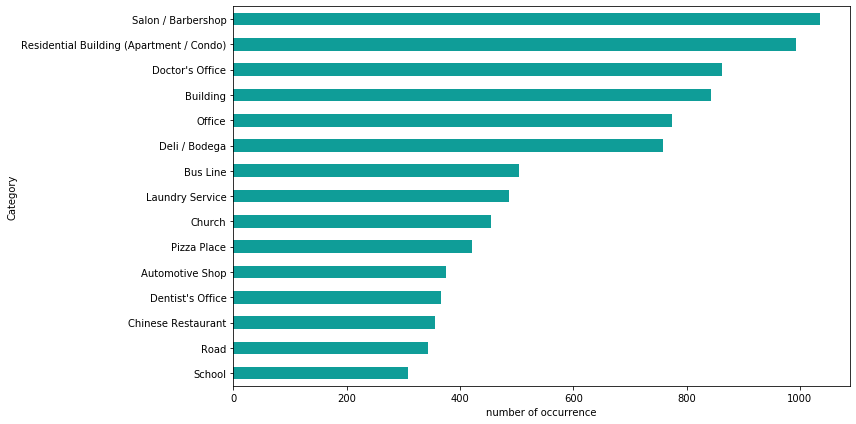

In [53]:
fig_size = (12,6)
fig, ax = plt.subplots(figsize=fig_size, facecolor='#ffffff')
tor_top_vc = NewYorkVenues['Venue Category'].value_counts(normalize=False)
ax = tor_top_vc.head(15).plot(kind='barh', color='#0f9d98');
ax.invert_yaxis()
ax.set_xlabel("number of occurrence")
ax.set_ylabel("Category")

plt.tight_layout()
fig.savefig('most-common-ven-nyc.png', dpi=300)

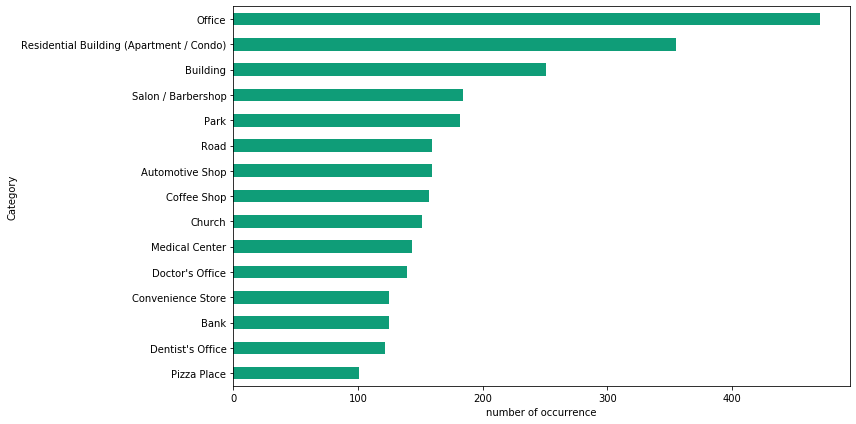

In [54]:
fig_size = (12,6)
fig, ax = plt.subplots(figsize=fig_size, facecolor='#ffffff')
tor_top_vc = TorontoVenues['Venue Category'].value_counts(normalize=False)
ax = tor_top_vc.head(15).plot(kind='barh', color='#0f9d78');
ax.invert_yaxis()
ax.set_xlabel("number of occurrence")
ax.set_ylabel("Category")

plt.tight_layout()
fig.savefig('most-common-ven-tor.png', dpi=300)

### now we will sort the venues category with the least frequencies

In [55]:
nyc_bot_vc = NewYorkVenues['Venue Category'].value_counts(normalize=False)
nyc_bot_vc = nyc_bot_vc.tail(15).to_frame('Count')
nyc_bot_vc.index.names = ['Venue Category']
nyc_bot_vc


,Count
Venue Category,
Circus,1
Cooking School,1
Botanical Garden,1
EV Charging Station,1
Other Event,1
Stadium,1
Recruiting Agency,1
Tree,1
Light Rail Station,1


In [56]:
tor_bot_vc = TorontoVenues['Venue Category'].value_counts(normalize=False)
tor_bot_vc = tor_bot_vc.tail(15).to_frame('Count')
tor_bot_vc.index.names = ['Venue Category']
tor_bot_vc

,Count
Venue Category,
Track,1
Creperie,1
Pakistani Restaurant,1
Baggage Claim,1
Vineyard,1
Museum,1
Newsagent,1
Irish Pub,1
Cuban Restaurant,1


In [57]:
# rare cateogries in both cities
nyc_tor_bot_vc = pd.concat([NewYorkVenues, TorontoVenues])['Venue Category'].value_counts(normalize=False)
nyc_tor_bot_vc = nyc_tor_bot_vc.tail(15).to_frame('Count')
nyc_tor_bot_vc.index.names = ['Venue Category']
nyc_tor_bot_vc

,Count
Venue Category,
Floating Market,1
Hot Spring,1
Monastery,1
Outdoor Event Space,1
Leather Goods Store,1
Stadium,1
Botanical Garden,1
Line / Queue,1
Forest,1
